# Классификация изображений

In [45]:
# Ячейка 1: Импорт библиотек
import kagglehub
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
# Настройка для воспроизводимости
tf.random.set_seed(42)
np.random.seed(42)

## Загружаем датасет

In [29]:
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\enoni\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1


In [6]:
pet_images_path = os.path.join(path, "PetImages")

# Проверим количество файлов
cat_folder = os.path.join(pet_images_path, "Cat")
dog_folder = os.path.join(pet_images_path, "Dog")

cat_files = os.listdir(cat_folder)
dog_files = os.listdir(dog_folder)

print(f"Количество изображений кошек: {len(cat_files)}")
print(f"Количество изображений собак: {len(dog_files)}")

# Посмотрим на примеры изображений
print("\nПримеры файлов кошек:")
print(cat_files[:5])
print("\nПримеры файлов собак:")
print(dog_files[:5])

Количество изображений кошек: 12501
Количество изображений собак: 12501

Примеры файлов кошек:
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg']

Примеры файлов собак:
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg']


Очистим от битых файлов

In [ ]:
for class_name in ['Cat', 'Dog']:
    folder = os.path.join(pet_images_path, class_name)
    for file in os.listdir(folder):
        if file.endswith('.jpg'):
            try:
                with Image.open(os.path.join(folder, file)) as img:
                    img.verify()
            except:
                os.remove(os.path.join(folder, file))
                print(f"Удален битый файл: {file}")

print("Очистка завершена!")

Очистка завершена!


Посмотрим на примеры изображений

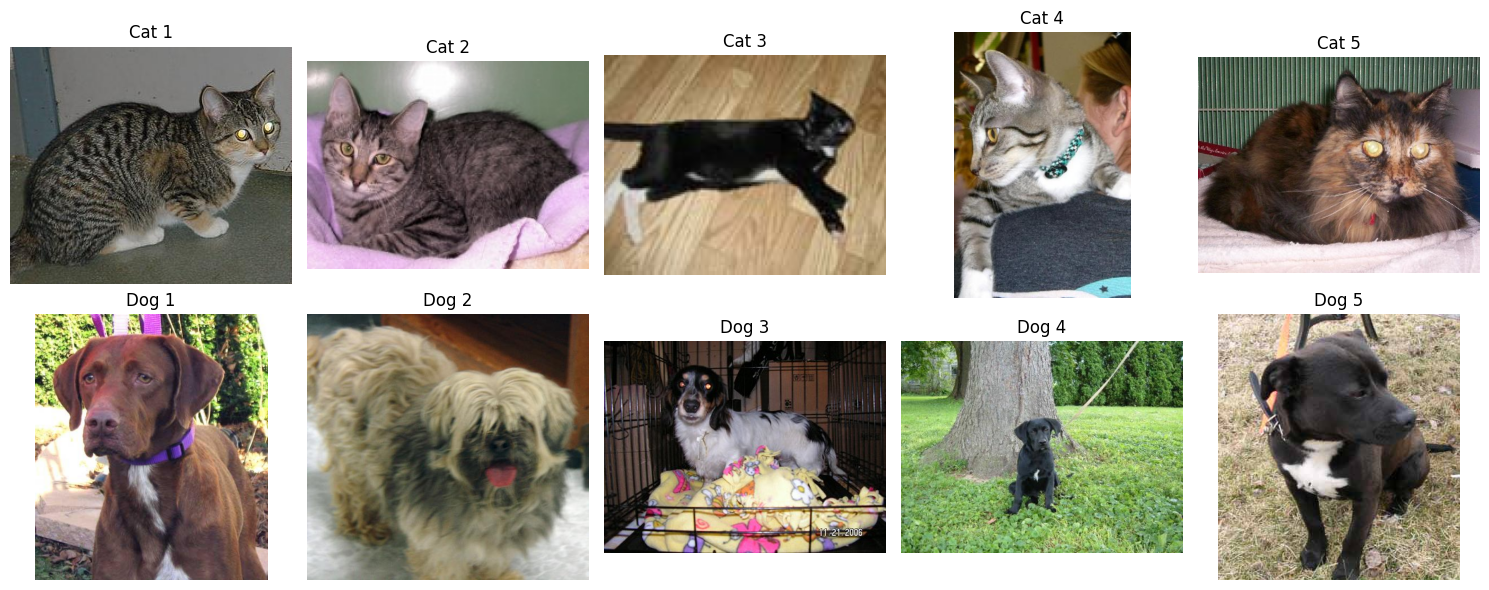

In [ ]:
def display_sample_images(cat_folder, dog_folder, num_samples=5):
    cat_files = [os.path.join(cat_folder, f) for f in os.listdir(cat_folder) if f.endswith('.jpg')]
    dog_files = [os.path.join(dog_folder, f) for f in os.listdir(dog_folder) if f.endswith('.jpg')]
    
    # Берем случайные примеры
    cat_samples = random.sample(cat_files, num_samples)
    dog_samples = random.sample(dog_files, num_samples)
    
    # Создаем график
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i, (cat_img, dog_img) in enumerate(zip(cat_samples, dog_samples)):
        # Кошки
        try:
            img_cat = Image.open(cat_img)
            axes[0, i].imshow(img_cat)
            axes[0, i].set_title(f'Cat {i+1}')
            axes[0, i].axis('off')
        except Exception as e:
            axes[0, i].text(0.5, 0.5, f'Error\n{str(e)[:20]}', 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
        
        # Собаки
        try:
            img_dog = Image.open(dog_img)
            axes[1, i].imshow(img_dog)
            axes[1, i].set_title(f'Dog {i+1}')
            axes[1, i].axis('off')
        except Exception as e:
            axes[1, i].text(0.5, 0.5, f'Error\n{str(e)[:20]}', 
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(cat_folder, dog_folder, 5)

Создаем генераторы данных

In [ ]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2, 
    rotation_range=15,       
    width_shift_range=0.1,   
    height_shift_range=0.1,   
    horizontal_flip=True,     
    zoom_range=0.1,           
    shear_range=0.2          
)

train_generator = train_datagen.flow_from_directory(
    pet_images_path,         
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training', 
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    pet_images_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

print(f"Классы: {train_generator.class_indices}")
print(f"Размер тренировочного набора: {train_generator.samples} изображений")
print(f"Размер валидационного набора: {validation_generator.samples} изображений")

Создаем генераторы данных...
Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Классы: {'Cat': 0, 'Dog': 1}
Размер тренировочного набора: 20000 изображений
Размер валидационного набора: 4998 изображений


Создаем CNN модель

In [ ]:
def create_balanced_model():
    model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model = create_balanced_model()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Обучаем модель

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

try:
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        verbose=1
    )
except Exception as e:
    print(f"Произошла ошибка: {e}")
print("Обучение завершено!")

Сохраняем модель 

In [ ]:
model.save('cats_vs_dogs_model.h5')
print("Модель сохранена!")

Модель сохранена!


График точности

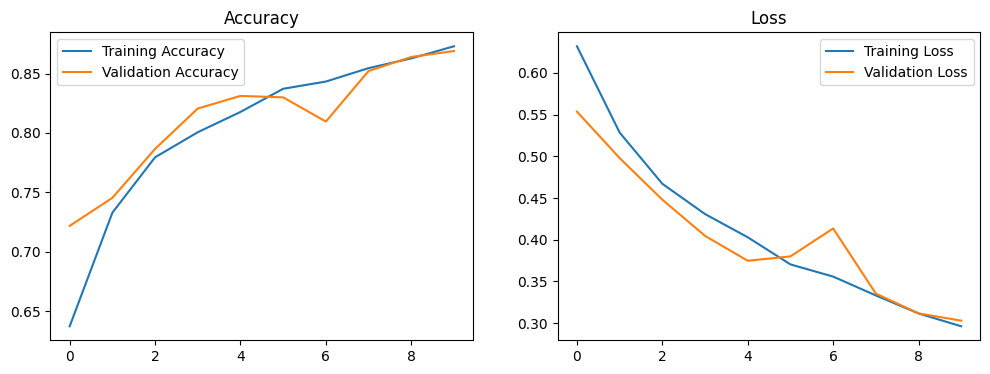

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

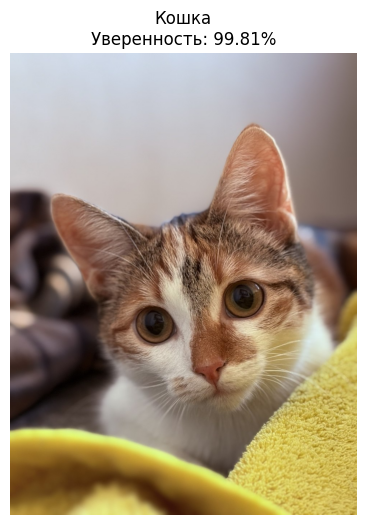

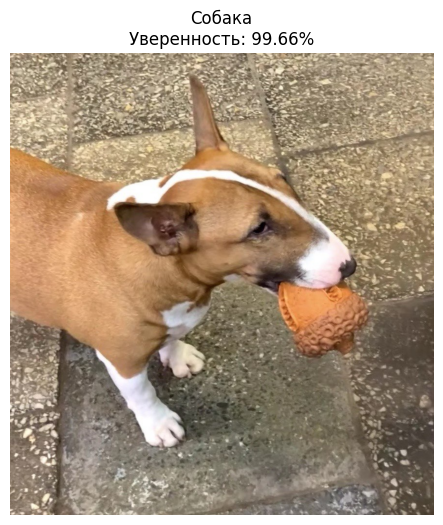

'Собака (уверенность: 99.66%)'

In [50]:
def predict_image(image_path):
    # Загрузка и предсказание
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0
    
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Определяем результат
    if prediction > 0.5:
        result_text = "Собака"
        confidence = prediction
    else:
        result_text = "Кошка" 
        confidence = 1 - prediction
    
    # Показываем изображение с результатом
    plt.figure(figsize=(6, 6))
    original_img = tf.keras.preprocessing.image.load_img(image_path)
    plt.imshow(original_img)
    plt.title(f'{result_text}\nУверенность: {confidence:.2%}', fontsize=12)
    plt.axis('off')
    plt.show()
    
    return f"{result_text} (уверенность: {confidence:.2%})"

result_cat = predict_image('cat.jpg')

result_cat
result_dog = predict_image('dog.jpg')

result_dog

Финальная оценка модели

In [ ]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Финальная точность на валидации: {test_accuracy:.2%}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.8718 - loss: 0.3062
Финальная точность на валидации: 87.15%
